<a href="https://colab.research.google.com/github/pankaj18/AI_for_medicine/blob/master/simpleitk/SimpleITK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install simpleitk
! pip install watermark
! pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=d0363c7215adc21203d2ce59475d0471ed3296d9244875ad5a84ebc0d928dee1
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [4]:
# file name and zenodo url
file_name  = "data.zip"
zenodo_url = "https://zenodo.org/record/3611368/files/" + file_name # 3611368 are the last digits of the
# specific version of dataset DOI

In [6]:
# download
# import the library to download the images from the web
import wget
wget.download(zenodo_url,".")

'./data.zip'

In [8]:
!unzip data.zip

Archive:  data.zip
   creating: knee/
  inflating: __MACOSX/._knee         
  inflating: knee/IM-0001-0097-0001.dcm  
  inflating: __MACOSX/knee/._IM-0001-0097-0001.dcm  
  inflating: knee/IM-0001-0005-0001.dcm  
  inflating: __MACOSX/knee/._IM-0001-0005-0001.dcm  
  inflating: knee/IM-0001-0073-0001.dcm  
  inflating: __MACOSX/knee/._IM-0001-0073-0001.dcm  
  inflating: knee/IM-0001-0133-0001.dcm  
  inflating: __MACOSX/knee/._IM-0001-0133-0001.dcm  
  inflating: knee/IM-0001-0107-0001.dcm  
  inflating: __MACOSX/knee/._IM-0001-0107-0001.dcm  
  inflating: knee/IM-0001-0047-0001.dcm  
  inflating: __MACOSX/knee/._IM-0001-0047-0001.dcm  
  inflating: knee/IM-0001-0031-0001.dcm  
  inflating: __MACOSX/knee/._IM-0001-0031-0001.dcm  
  inflating: knee/IM-0001-0079-0001.dcm  
  inflating: __MACOSX/knee/._IM-0001-0079-0001.dcm  
  inflating: knee/IM-0001-0013-0001.dcm  
  inflating: __MACOSX/knee/._IM-0001-0013-0001.dcm  
  inflating: knee/IM-0001-0081-0001.dcm  
  inflating: __MACOSX/knee/

In [9]:
ls 

data.zip  knee/  __MACOSX/  mask_gt.mha  mask.mha  sample_data/


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from ipywidgets import * # for display
from ipywidgets import HBox, VBox
from ipywidgets import interactive
from ipywidgets import Layout
from ipywidgets import widgets as widgets

We have three images:
- A dicom stack of a knee (knee)
- A mask of femoral knee cartilage computed with our - latest segmentation algorithm (mask.mha)
- A ground truth segmentation (mask_gt.mha).

We want:
- Visually evaluate the quality of the segmentation
- Compute the difference between the two segmentations in terms of overlapping voxels
- Compute the difference between the cartilage volumes calculated from the two masks (in [mm])

Through this task we will learn how to:
- Read a dicom stack
- Read a metafile image
- Print out image characteristics
- Visualize an image
- Use a filter (e.g Dice Similarity Coefficient)
- Calculate mask volume

In [10]:
def show_image_slice(slice):
    
    """
    Show one slice of an image
    Input: 2D slice in SimpleITK format
    """
    
    # figure size in notebook
    plt.rcParams['figure.figsize'] = [5, 5]

    # -> Task 1: Note the function GetArrayViewFromImage. What does it do? 
    np_slice = sitk.GetArrayViewFromImage(slice)     
    
    # flip the slice upside-down for visualization
    np_slice = np.flipud(np_slice)
    
    # plot with matplotlib
    plt.imshow(np_slice, 'gray', interpolation=None, origin='lower')
    plt.axis('off')
    plt.show()

In [12]:
def show_image_interactive (img, mask=None):  
    
    """
    Show image using slider 
    Inputs: 
    - 3D image in SimpleITK format
    - 3D mask in SimpleITK format (optional)
    """  
    
    # convert image to numpy array for compatibility with matplotlib
    np_img  = sitk.GetArrayViewFromImage(img)
    if mask != None:
        np_mask = sitk.GetArrayViewFromImage(mask)
        
    
    # variables 
    n_of_slices = np_img.shape[0]
    first_slice_viz = 30
    
        
    # function for slider
    def view_image(slider):
        
        # get slice of image
        slice_np_img = np_img[slider,:,:] 
        
        # flip the slice upside-down for visualization
        slice_np_img = np.flipud(slice_np_img)
        
        if mask != None: 
            # get slice of mask
            slice_np_mask = np_mask[slider,:,:]
            # flip the slice upside-down for visualization
            slice_np_mask = np.flipud(slice_np_mask)
            # mask for transparency
            slice_np_mask = np.ma.masked_where(slice_np_mask == 0, slice_np_mask)

        # show both
        plt.imshow(slice_np_img, cmap=plt.cm.gray, origin='lower',interpolation=None) 
        if mask != None: 
            plt.imshow(slice_np_mask, 'hsv' , interpolation=None, origin='lower', alpha=1, vmin=0, vmax=100) 
        plt.axis('off')

        
    # link sliders and its function
    slider_image = interactive(view_image, 
                         slider = widgets.IntSlider(  min     = 0, 
                                                      max     = n_of_slices, 
                                                      value   = first_slice_viz,
                                                      step    = 1,
                                                      layout  = Layout(width='180px'),
                                                      readout = False,
                                                      continuous_update = False, # avoids intermediate image display,
                                                      description       = 'Slice n.'))
    # show figures before start interacting
    slider_image.update()  
    
    # slice number scrolling
    text = widgets.BoundedIntText( min    = 0, 
                                   max    = n_of_slices, 
                                   value  = first_slice_viz,
                                   step   = 1,
                                   layout = Layout(width='50px'),
                                   continuous_update = False, 
                                   description       = "") # BoundedIntText to avoid that displayed text goes outside of the range)
    
    # link slider and text 
    widgets.jslink((slider_image.children[:-1][0], 'value'), (text, 'value'))
    
    # layout
    slider_box   = HBox(slider_image.children[:-1])
    widget_box   = HBox([slider_box, text])
    whole_box    = VBox([widget_box, slider_image.children[-1] ]) 
        
    return whole_box

# Visually evaluate the quality of the segmentations

In [13]:
image_folder = "./knee"
reader      = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(image_folder)  
reader.SetFileNames(dicom_names)
img         = reader.Execute()

In [14]:
print("Origin : " + str(img.GetOrigin()))    
print("Spacing: " + str(img.GetSpacing()))
print("Size   : " + str(img.GetSize() )) 

Origin : (-4.9376, -57.9613, 86.4)
Spacing: (0.3125, 0.3125, 1.5000059701492536)
Size   : (512, 512, 68)


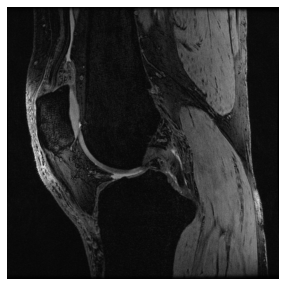

In [18]:
#Visualize one image slice
slice_id = 30
slice = img[:,:,slice_id]
show_image_slice (slice) 

In [19]:
# Browse the 3D image:
show_image_interactive(img)

In [20]:
# Read mask.mha
# Read the metafile
mask = sitk.ReadImage("./mask.mha")
show_image_interactive(img, mask)

In [21]:
# Read mask_gt.mha
# Read the metafile:
mask_gt = sitk.ReadImage("./mask_gt.mha")
show_image_interactive(img, mask_gt)

# Compute the difference between the two segmentations in terms of overlapping voxels

In [23]:
# Declare the filter 
filter     = sitk.LabelOverlapMeasuresImageFilter()

# Execute the filter 
filter.Execute(mask,mask_gt ) # Task 1: What are the inputs?

# Get the DSC and print it out
dice_coeff = filter.GetDiceCoefficient()
print ("The Dice Similarity Coefficient is :" + "{:.2f}".format(dice_coeff))

The Dice Similarity Coefficient is :0.99


Computer the difference between the cartilage volumes calculated from the two masks (in [mm])

In [26]:
# sitk to numpy
mask_py = sitk.GetArrayFromImage(mask)

# get number of white voxels
n_of_voxels = np.count_nonzero(mask_py)

# calculate volume in voxels
volume_vx = n_of_voxels

# calculate volume in mm 
volume_mm = volume_vx *  mask.GetSpacing()[0] * mask.GetSpacing()[1] * mask.GetSpacing()[2]                     

# print out volume
print ("The volume is: " + "{:.2f}".format(volume_mm) + " [mm]")

The volume is: 11582.23 [mm]


Calculate volume for mask_gt.mha

In [27]:
# sitk to numpy
mask_gt_py = sitk.GetArrayFromImage(mask_gt)

# get number of white voxels
n_of_voxels = np.count_nonzero(mask_gt_py)

# calculate volume in voxels
volume_vx = n_of_voxels

# calculate volume in mm 
volume_mm =  volume_vx * mask_gt.GetSpacing()[0] * mask_gt.GetSpacing()[1] * mask_gt.GetSpacing()[2]                       
# print out volume
print ("The volume is: " + "{:.2f}".format(volume_mm) + " [mm]")

The volume is: 11729.59 [mm]


In [28]:
def calculate_volume(mask): 
    
    """
    Write here function documentation
    """
    # sitk to numpy
    mask_py = sitk.GetArrayFromImage(mask)
    # get number of white voxels
    n_of_voxels = np.count_nonzero(mask_py)
    # calculate volume in voxels
    volume_vx = n_of_voxels
    # calculate volume in mm 
    volume_mm =  volume_vx * mask.GetSpacing()[0] * mask.GetSpacing()[1] * mask.GetSpacing()[2]            
    print ("The volume is: " + "{:.2f}".format(volume_mm) + " [mm]")
    return volume_mm


In [29]:
vol    = calculate_volume(mask)

The volume is: 11582.23 [mm]


In [30]:
vol_gt = calculate_volume(mask_gt)

The volume is: 11729.59 [mm]


In [32]:
diff = vol - vol_gt

In [33]:
print ("The volume difference is: " + "{:.2f}".format(diff) + " [mm]")

The volume difference is: -147.36 [mm]
